S<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>
<h1 align="center">Agent Parameter Extraction Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating agent tool parameter extraction,
- to provide an experimental framework for users to iterate and improve on the default agent tool parameter extraction template.

## Install Dependencies and Import Libraries

In [ ]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [ ]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28'

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to

*   List item
*   List item

be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import os
import json
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

import phoenix.evals.default_templates as templates
from phoenix.evals import (
    OpenAIModel,
    TOOL_PARA,
    TOOL_CALLING_PROMPT_RAILS_MAP,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of a few example user prompts, with corresponding tool choices and ground truth answers, in addition to an evaluation prompt template against benchmark datasets of user queries and the corresponding tools called with ground-truth labels. We will be using the Berkely Function-Calling Leaderboard dataset. This dataset is commonly used for Agent applications that call tools as a benchmark.

In [ ]:
 !wget -O exec_simple.json https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json

--2025-06-23 17:48:20--  https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json
Resolving huggingface.co (huggingface.co)... 3.167.112.96, 3.167.112.25, 3.167.112.38, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201542 (1.1M) [text/html]
Saving to: ‘exec_simple.json’

exec_simple.json    100%[===================>]   1.15M  --.-KB/s    in 0.03s   

2025-06-23 17:48:20 (44.4 MB/s) - ‘exec_simple.json’ saved [1201542/1201542]



In [ ]:
import json
import requests
import pandas as pd
from phoenix.evals import OpenAIModel, llm_classify

# Load dataset
url = "https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/resolve/main/BFCL_v3_exec_multiple.json"
response = requests.get(url)
dataset = [json.loads(line) for line in response.text.strip().splitlines()]

# Collect all unique tool definitions (these are all the tools the agent can choose from)
unique_tools = {}
for entry in dataset:
    for tool in entry.get("function", []):
        if tool["name"] not in unique_tools:
            unique_tools[tool["name"]] = tool

# Gather the tools and corresponding parameters
tool_definitions_text = "\n".join(
    f"{tool['name']}: {tool['description']} | Parameters: {json.dumps(tool['parameters'])}"
    for tool in unique_tools.values()
)


# Prepare data for evaluation
eval_data = []
for entry in dataset:
    question = entry["question"][0][0]["content"]
    ground_truths = entry.get("ground_truth", [])
    for gt in ground_truths:
        eval_data.append({
            "question": question,
            "tool_call": gt,
            "tool_definitions": tool_definitions_text
        })

df_eval = pd.DataFrame(eval_data)
df.head()


,question,tool_call,tool_definitions,label
0,"I've been playing a game where rolling a six is somehow more likely than usual, and the chance of it happening on a single roll is 60%. I'm curious, if I roll the die 20 times, what are the odds that I'll get exactly five sixes?","{""tool"": ""calc_binomial_probability"", ""n"": 20, ""k"": 5, ""p"": 0.6}","[{""name"": ""calc_binomial_probability"", ""description"": ""Calculates the probability of getting k successes in n trials."", ""parameters"": {""type"": ""dict"", ""properties"": {""n"": {""type"": ""integer"", ""description"": ""The number of trials.""}, ""k"": {""type"": ""integer"", ""description"": ""The number of successes.""}, ""p"": {""type"": ""float"", ""description"": ""The probability of success.""}}, ""required"": [""n"", ""k"", ""p""]}}]",correct
1,"During last night's basketball game, one of the star players was on fire, attempting a whopping 30 free throws. It's generally known that the average success rate for free throws hovers around 50%. I'm curious, with that success probability, what are the chances that the player made exactly 15 out of those 30 attempts?","{""tool"": ""calc_binomial_probability"", ""n"": 30, ""k"": 15, ""p"": 0.5}","[{""name"": ""calc_binomial_probability"", ""description"": ""Calculates the probability of getting k successes in n trials."", ""parameters"": {""type"": ""dict"", ""properties"": {""n"": {""type"": ""integer"", ""description"": ""The number of trials.""}, ""k"": {""type"": ""integer"", ""description"": ""The number of successes.""}, ""p"": {""type"": ""float"", ""description"": ""The probability of success.""}}, ""required"": [""n"", ""k"", ""p""]}}]",correct
2,"I'm currently tweaking a machine learning model and I need to understand the similarity between two objects in my dataset. Their characteristics are expressed in the feature vectors [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second one. Could you calculate the cosine similarity between these two feature vectors to help me determine how similar these objects are?","{""tool"": ""calculate_cosine_similarity"", ""vectorA"": ""[0.5"", ""vectorB"": ""[0.4""}","[{""name"": ""calculate_cosine_similarity"", ""description"": ""Calculates the cosine similarity of two vectors."", ""parameters"": {""type"": ""dict"", ""properties"": {""vectorA"": {""type"": ""array"", ""items"": {""type"": ""float""}, ""description"": ""The first vector.""}, ""vectorB"": {""type"": ""array"", ""items"": {""type"": ""float""}, ""description"": ""The second vector.""}}, ""required"": [""vectorA"", ""vectorB""]}}]",correct
3,"I'm working on a project that involves comparing the attributes of different entities to determine how similar they are. I have two entities represented by numerical arrays, and I need to use cosine similarity as a measure of similarity between them. The attributes for the first entity are [0.3, 0.8, 0.1, 0.6, 0.2], and for the second entity, they are [0.5, 0.7, 0.4, 0.9, 0.3]. Could you calculate the cosine similarity for these two vectors for me?","{""tool"": ""calculate_cosine_similarity"", ""vectorA"": ""[0.3"", ""vectorB"": ""[0.5""}","[{""name"": ""calculate_cosine_similarity"", ""description"": ""Calculates the cosine similarity of two vectors."", ""parameters"": {""type"": ""dict"", ""properties"": {""vectorA"": {""type"": ""array"", ""items"": {""type"": ""float""}, ""description"": ""The first vector.""}, ""vectorB"": {""type"": ""array"", ""items"": {""type"": ""float""}, ""description"": ""The second vector.""}}, ""required"": [""vectorA"", ""vectorB""]}}]",correct
4,I'm working on a physics experiment and need to calculate the density of an object I have. It weighs 50 kilograms and takes up a space of 10 cubic meters. Could you help me figure out its density?,"{""tool"": ""calculate_density"", ""mass"": 50.0, ""volume"": 10.0}","[{""name"": ""calculate_density"", ""description"": ""Calculates the density of an object."", ""

## Display Agent Tool Calling Prompt Template

View the default template used to evaluate agent tool calling. You can tweak this template and evaluate its performance relative to the default.

In [ ]:
print(templates.TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

#

## Configure the LLM

Configure your API keys.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key


# if not (anthropic_api_key := os.getenv("ANTHROPIC_API_KEY")):
#    openai_api_key = getpass("🔑 Enter your Anthropic API key: ")
#anthropic_api_key.api_key = anthropic_api_key
# os.environ["ANTHROPIC_API_KEY"] = anthropic_api_key


🔑 Enter your OpenAI API key: ··········


## Evaluate the Dataset Using Phoenix

In [ ]:
# Define judge prompt

agent_tool_extraction_prompt_template = """
You are comparing a function call response to a question and trying to determine if the generated call has extracted the exact right parameters from the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [LLM Response]: {response}
    ************
    [END DATA]

Compare the parameters in the generated function against the JSON provided below.
The parameters extracted from the question must match the JSON below exactly.
Your response must be single word, either "correct", "incorrect", or "not-applicable",
and should not contain any text or characters aside from that word.

"correct" means the function call parameters match the JSON below and provides only relevant information.
"incorrect" means that the parameters in the function do not match the JSON schema below exactly, or the generated function does not correctly answer the user's question. You should also respond with "incorrect" if the response makes up information that is not in the JSON schema.
"not-applicable" means that response was not a function call.

Here is more information on each function:
{function_defintions}
"""

# Run the classifier
model = OpenAIModel(model="4o-mini", temperature=0.0)
results = llm_classify(
    data=df_eval,
    template=agent_tool_extraction_prompt_template,
    model=model,
    rails=["correct", "incorrect"],
    provide_explanation=False
)

df_eval = pd.concat([df_eval, results], axis=1)
df_eval.to_csv("judge_results.csv", index=False)
print(df_eval.head())


llm_classify |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

                                                                                                                                                                                                                                                                                                                                                                         question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar

Eval template variables:

- **input** : The document text to summarize
- **output** : The summary of the document

## Show Results

Classification Report:

              precision    recall  f1-score   support

     correct       1.00      1.00      1.00        50
   incorrect       0.00      0.00      0.00         0

    accuracy                           1.00        50
   macro avg       0.50      0.50      0.50        50
weighted avg       1.00      1.00      1.00        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

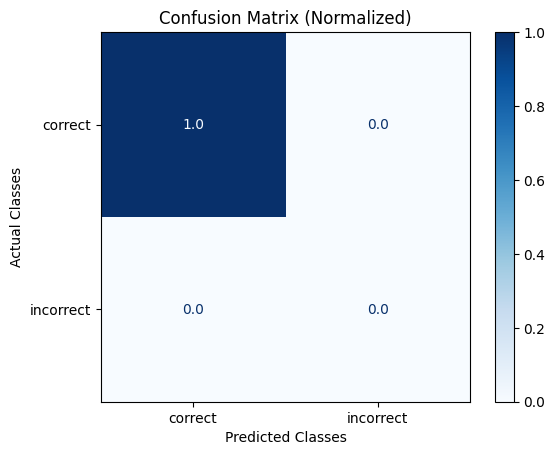

In [ ]:
# These are the labels we *assume* are correct (ground truth tool calls)
true_labels = ["correct"] * len(df_eval)

# These are the LLM-as-a-Judge predictions from your prompt
judge_labels = df_eval["label"].tolist()

# Set of classification categories expected
rails = ["correct", "incorrect"]

from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(true_labels, judge_labels, labels=rails))

from pycm import ConfusionMatrix

confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=judge_labels,
    classes=rails,
)

confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)
